## This code computes Expected Coverage Probabilities (ECPs) using `tarp` method for a range of smoothing scales.

In [1]:
import os, sys, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from tarp import get_tarp_coverage

import torch
from torch.utils.data import DataLoader

sys.path.append('../')
from utils import datasets
import utils.resnet_cond as resnet
import utils.lightning_flows as LFlows


/n/home11/aakhmetzhanova/.conda/envs/ccl-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Load model and maps

In [3]:
field      = 'Mgas'
home_dir   = Path("/n/netscratch/dvorkin_lab/Lab/aakhmetzhanova/evidence-estimation-Astrid/") 
save_dir   = home_dir / f"trained_models/Maps_{field}/"


In [4]:
# Load summarizer and density estimator.
npe_k_cond = False
n_params   = 6
summary_dim = 40

checkpoint = save_dir / f'summarizer_scale_cond_{field}_Astrid/'
checkpoint = checkpoint / 'k_conv_lr_1e-4/checkpoints/best_val_loss.ckpt'
model      = LFlows.LightningFlowCond.load_from_checkpoint(checkpoint, 
                                                           device=device,
                                                           k_cond='conv',
                                                           npe_k_cond=npe_k_cond,
                                                           summary_dim=summary_dim, n_params=n_params,
                                                           model_name='resnet10t.c3_in1k',)
model.summarizer.eval();
model.density_estimator.eval();

log_p = lambda summaries: model.density_estimator(summaries)

In [19]:
# Load maps
minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])[:n_params] 
maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])[:n_params] 

splits    = 15
grid      = 256

set_name = 'LH' 

params_A   = np.loadtxt(home_dir / f'data/params_{set_name}_Astrid.txt',)[:, :n_params]
params_A  = (params_A - (minimum+maximum)/2)/((maximum - minimum)/2)   # rescale parameters
params_A  = np.repeat(params_A[:, None, :], splits, axis = 1) # reshape the parameters to match the shape of the maps

params_S  = np.loadtxt(home_dir / f'data/params_{set_name}_SIMBA.txt',)[:, :n_params] 
params_S  = (params_S - (minimum+maximum)/2)/((maximum - minimum)/2)   # rescale parameters
params_S  = np.repeat(params_S[:, None, :], splits, axis = 1) # reshape the parameters to match the shape of the maps

params_I   = np.loadtxt(home_dir / f'data/params_{set_name}_IllustrisTNG.txt',)[:, :n_params] 
params_I  = (params_I - (minimum+maximum)/2)/((maximum - minimum)/2)   # rescale parameters
params_I  = np.repeat(params_I[:, None, :], splits, axis = 1) # reshape the parameters to match the shape of the maps


dset_size = params_A.shape[0]
maps_A    = np.load(home_dir / f'data/2D/Maps_{field}_Astrid_{set_name}_z=0.00.npy').reshape(dset_size, -1, 1, grid, grid)[:, :splits] 
maps_S    = np.load(home_dir / f'data/2D/Maps_{field}_SIMBA_{set_name}_z=0.00.npy').reshape(dset_size, -1, 1, grid, grid)[:, :splits]
maps_I    = np.load(home_dir / f'data/2D/Maps_{field}_IllustrisTNG_{set_name}_z=0.00.npy').reshape(dset_size, -1, 1, grid, grid)[:, :splits] 

# Normalization constants
maps    = np.load(home_dir  / f'data/2D/Maps_{field}_Astrid_LH_z=0.00.npy').reshape(1000, -1, 1, grid, grid)[:, :splits]
maps_mean, maps_std = np.log10(maps).mean(), np.log10(maps).std()


## Compute expected coverage probabilities with TARP

In [53]:
def coverage_levels(log_p,
                    maps_set, params_set,
                    maps_mean, maps_std,
                    k_smooth_array, num_bootstrap=100,
                    n_samples=10_000, params_idx=None,
                    train_frac=0.9, valid_frac=0.05, test_frac=0.05,
                    seed=1, batch_size=100):
    # compute params for IllustrisTNG
    levels_all_scales = []
    coverages_all_scales = []

    for i, k_smooth in enumerate(k_smooth_array):
        t1 = time.time()
        
        params_sampled = []
        params_true = []
        

        _, _, dset = datasets.create_datasets_maps(maps_set, params_set, 
                                                       train_frac, valid_frac, test_frac, 
                                                       seed=seed, rotations=False, 
                                                       smoothing=True, k_smooth=k_smooth,
                                                       k_min=k_min, k_max=k_max+1e-2,
                                                       normalize_k=True,
                                                       linear=False, log_scale=True, 
                                                       standardize=True, 
                                                       maps_mean=maps_mean, maps_std=maps_std,)
        dataloader  = DataLoader(dset, batch_size, shuffle = False, )

        for maps_test, params_test, k_test in dataloader:
            with torch.no_grad():
                maps_test    = maps_test.float().to(device=device)
                params_test  = params_test.float().to(device=device)
                k_test       = k_test.float().to(device=device)
                bs           = maps_test.shape[0]

                summaries_batch = model.summarizer([maps_test, k_test])
                if npe_k_cond:
                    summaries_batch  = torch.cat((summaries_batch, k_test), dim=1)
                
                params_sampled_batch = model.density_estimator(summaries_batch).sample((n_samples,))
                
                
                params_sampled.append(params_sampled_batch.cpu().numpy())
                params_true.append(params_test.cpu().numpy())
                
        
        params_sampled = np.concatenate(params_sampled, axis=1)
        params_true    = np.concatenate(params_true, axis=0)
        
        if params_idx is not None:
            params_sampled = params_sampled[:, :, params_idx]
            params_true    = params_true[:, params_idx]
            
        print(params_sampled.shape, params_true.shape)
        ecp, alpha = get_tarp_coverage(params_sampled, params_true, 
                                       norm=True, references='random', 
                                       metric='euclidean', 
                                       bootstrap=True,
                                       num_bootstrap=num_bootstrap) 
        
        coverages_all_scales.append(ecp)
        levels_all_scales.append(alpha)
        
    return levels_all_scales, coverages_all_scales
    
    
    

In [ ]:
# Set smoothing scales to use for computing coverages
k_min, k_max   = 2., 45
k_smooth_array = np.logspace(np.log10(k_min), np.log10(k_max), num=10)

results_dir = Path("results/") 


# Compute coverages for each suite
levels_A, coverages_A = coverage_levels(log_p,
                maps_A, params_A, maps_mean, maps_std,
                k_smooth_array, params_idx=[0, 1],)

levels_S, coverages_S = coverage_levels(log_p,
                maps_S, params_S, maps_mean, maps_std,
                k_smooth_array, params_idx=[0, 1],)

levels_I, coverages_I = coverage_levels(log_p,
                maps_I, params_I, maps_mean, maps_std,
                k_smooth_array, params_idx=[0, 1],)

# Save results for plotting.
results_dir = Path("results/")
np.save(results_dir / '{:s}_ecp_levels_SIMBA_LH_test.npy'.format(field), np.asarray(levels_S))
np.save(results_dir / '{:s}_ecp_levels_Astrid_LH_test.npy'.format(field), np.asarray(levels_A))
np.save(results_dir / '{:s}_ecp_levels_IllustrisTNG_LH_test.npy'.format(field), np.asarray(levels_I))

np.save(results_dir / '{:s}_ecp_vals_SIMBA_LH_test.npy'.format(field), np.asarray(coverages_S))
np.save(results_dir / '{:s}_ecp_vals_Astrid_LH_test.npy'.format(field), np.asarray(coverages_A))
np.save(results_dir / '{:s}_ecp_vals_IllustrisTNG_LH_test.npy'.format(field), np.asarray(coverages_I))

### Plot expected coverages for different suites

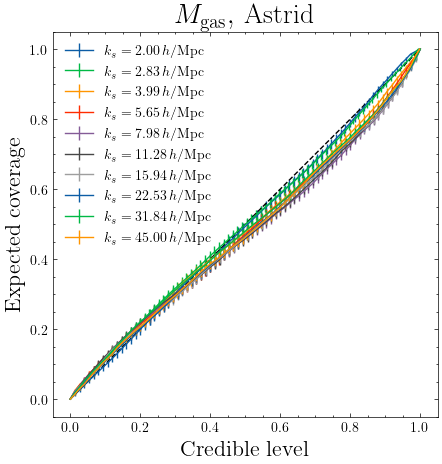

In [56]:
plt.style.use('science')
plt.figure(figsize=(5, 5))
plt.title(r'$M_{\mathrm{gas}}, \, \mathrm{Astrid}$', fontsize=20)
for i, (levels, coverages) in enumerate(zip(levels_A, coverages_A)):
    plt.errorbar(levels, np.mean(coverages, axis=0), yerr=np.std(coverages, axis=0),
                 label = r'$k_s = {:.2f} \, h/$'.format(k_smooth_array[i]) + 'Mpc')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel(r'Credible level', fontsize=16)
plt.ylabel(r'Expected coverage', fontsize=16)
plt.legend(loc='best', fontsize=10)
plt.gca().set_aspect('equal')


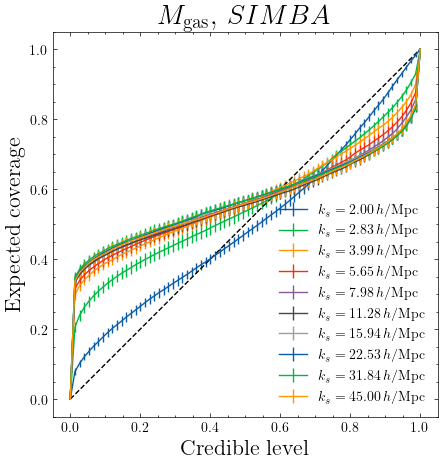

In [57]:
plt.style.use('science')
plt.figure(figsize=(5, 5))
plt.title(r'$M_{\mathrm{gas}}, \, SIMBA $', fontsize=20)
for i, (levels, coverages) in enumerate(zip(levels_S, coverages_S)):
    plt.errorbar(levels, np.mean(coverages, axis=0), yerr=np.std(coverages, axis=0),
                 label = r'$k_s = {:.2f} \, h/$'.format(k_smooth_array[i]) + 'Mpc')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel(r'Credible level', fontsize=16)
plt.ylabel(r'Expected coverage', fontsize=16)
plt.legend(loc='best', fontsize=10)
plt.gca().set_aspect('equal')


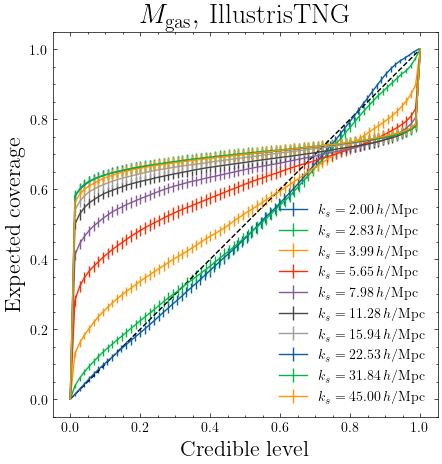

In [58]:
plt.style.use('science')
plt.figure(figsize=(5, 5))
plt.title(r'$M_{\mathrm{gas}}, \, \mathrm{IllustrisTNG}$', fontsize=20)
for i, (levels, coverages) in enumerate(zip(levels_I, coverages_I)):
    plt.errorbar(levels, np.mean(coverages, axis=0), yerr=np.std(coverages, axis=0),
                 label = r'$k_s = {:.2f} \, h/$'.format(k_smooth_array[i]) + 'Mpc')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel(r'Credible level', fontsize=16)
plt.ylabel(r'Expected coverage', fontsize=16)
plt.legend(loc='best', fontsize=10)
plt.gca().set_aspect('equal')


In [59]:
# Save results for plotting.
results_dir = Path("results/")
np.save(results_dir / '{:s}_ecp_levels_SIMBA_LH_test.npy'.format(field), np.asarray(levels_S))
np.save(results_dir / '{:s}_ecp_levels_Astrid_LH_test.npy'.format(field), np.asarray(levels_A))
np.save(results_dir / '{:s}_ecp_levels_IllustrisTNG_LH_test.npy'.format(field), np.asarray(levels_I))


np.save(results_dir / '{:s}_ecp_vals_SIMBA_LH_test.npy'.format(field), np.asarray(coverages_S))
np.save(results_dir / '{:s}_ecp_vals_Astrid_LH_test.npy'.format(field), np.asarray(coverages_A))
np.save(results_dir / '{:s}_ecp_vals_IllustrisTNG_LH_test.npy'.format(field), np.asarray(coverages_I))